# Open Data Shanghai 2016 [2016_12_10-11]
## Pragmatic NLP - Live Demo
### Dataset: CNN Facebook Posts 2012-2016
Source: https://data.world/martinchek/2012-2016-facebook-posts

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from textblob import TextBlob
# Don't forget to fetch necesarry models for TextBlob's NLTK hooks to function > 'python -m textblob.download_corpora'

import json
import multiprocessing
import regex as re

In [2]:
fname_data = '/Volumes/SD/datasets/facebook-news/cnn-5550296508.csv-cnn-5550296508.csv'

## 1. Ingest Data

In [3]:
pd_data = pd.read_csv(fname_data, encoding='utf-16', na_values='NULL', quoting=1)

In [ ]:
pd_data.id = pd_data['id'].map(lambda x : x.replace('"',''))

In [195]:
pd_msg = pd_data[['id', 'message', 'likes_count']]
pd_msg = pd_msg.dropna()
pd_msg.head(10)

,id,message,likes_count
0,﻿5550296508_10150712177946509,Breaking News: French prosecutors: Former IMF ...,348
1,﻿5550296508_258636547563092,CNN Opinion Contributor Richard Chasdi states ...,542
2,﻿5550296508_10150712540566509,"'Ceglia has forged documents, destroyed eviden...",185
3,﻿5550296508_350156181698587,An Orlando Sentinel report fills in some blank...,488
4,﻿5550296508_140431756086124,At the core of the health care law is the indi...,538
5,﻿5550296508_10150714165126509,Breaking News: CNN/ORC poll: Majority of Repub...,385
7,﻿5550296508_344070822311532,A 'super Wi-Fi' network; Windows 8; the Lytro ...,676
8,﻿5550296508_10150714559081509,The Supreme Court is hearing a debate on healt...,499
9,﻿5550296508_10150714800171509,Breaking News: Newt Gingrich replacing campaig...,200
10,﻿5550296508_257573827669337,“Speaker Gingrich is committed to going all th...,208


In [162]:
pd_msg.count()

id             31091
message        31091
likes_count    31091
dtype: int64

In [196]:
pd_msg['length'] = pd_msg['message'].map(lambda x: len(x) if isinstance(x, str) else None)
pd_msg.head()

,id,message,likes_count,length
0,﻿5550296508_10150712177946509,Breaking News: French prosecutors: Former IMF ...,348,132
1,﻿5550296508_258636547563092,CNN Opinion Contributor Richard Chasdi states ...,542,393
2,﻿5550296508_10150712540566509,"'Ceglia has forged documents, destroyed eviden...",185,235
3,﻿5550296508_350156181698587,An Orlando Sentinel report fills in some blank...,488,277
4,﻿5550296508_140431756086124,At the core of the health care law is the indi...,538,253


## 2. Pre-processing

The idea here is to get our text data to be as clean & uniform as possible, while trying to reduce the noise.

We also want to regroup all documents in a single corpus to prepare for the modeling steps.

#### Build some utility functions to filter out unwanted pieces (get familiar with your dataset!)

In [8]:
pd_msg['message'][2]

"'Ceglia has forged documents, destroyed evidence, and abused the judicial system in furtherance of his criminal scheme. Ceglia must be held accountable,' states Facebook’s attorney. http://cnnmon.ie/HdBpwG See how the drama unfolded.  "

Let's clean this up a bit by removing URLs as we won't be needing them here (we could also extract them and put them in a separate column). We can also make sure we only get valid token by limiting via a regex pattern and by throwing out stopwords.

In [9]:
from nltk.corpus import stopwords
stp = set(stopwords.words('english'))

In [10]:
re_filter_token = re.compile('\w{2,}')
def get_valid_tokens(text):
    return re_filter_token.findall(text)

In [11]:
def filter_urls(text):
    re_url = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(re_url, '', text)
' '.join(get_valid_tokens(filter_urls(pd_msg['message'][2])))

'Ceglia has forged documents destroyed evidence and abused the judicial system in furtherance of his criminal scheme Ceglia must be held accountable states Facebook attorney See how the drama unfolded'

Next, I'd like to apply Lemmatization to get the real root of my tokens. For this I need to retrieve the POS tags as well, in order for the morphological parser to apply the correct lemmatization operation.

In [12]:
# Let's have a look at how TextBlob returns POS data...
txt = TextBlob(filter_urls(pd_msg['message'][2].replace("'", '')))  # list of (word, POS) pairs
txt_tags = txt.tags
txt_tags

[('Ceglia', 'NNP'),
 ('has', 'VBZ'),
 ('forged', 'VBN'),
 ('documents', 'NNS'),
 ('destroyed', 'VBD'),
 ('evidence', 'NN'),
 ('and', 'CC'),
 ('abused', 'VBD'),
 ('the', 'DT'),
 ('judicial', 'JJ'),
 ('system', 'NN'),
 ('in', 'IN'),
 ('furtherance', 'NN'),
 ('of', 'IN'),
 ('his', 'PRP$'),
 ('criminal', 'JJ'),
 ('scheme', 'NN'),
 ('Ceglia', 'NNP'),
 ('must', 'MD'),
 ('be', 'VB'),
 ('held', 'VBN'),
 ('accountable', 'JJ'),
 ('states', 'NNS'),
 ('Facebook’s', 'NNP'),
 ('attorney', 'NN'),
 ('See', 'VB'),
 ('how', 'WRB'),
 ('the', 'DT'),
 ('drama', 'NN'),
 ('unfolded', 'VBD')]

#### Combine all your preprocessing task into a single pipeline (function)

In [28]:
# We can use POS information to apply lemmatization and obtain each token root
# Let's build a simple preprocessing pipeline using what we got so far
def preprocess_text(text, as_list=False):
    if isinstance(text, tuple):
        text = text[1]
    POS_KEEPS = ['v', 'n', 'j']
    POS_LEMMA = ['v', 'n']
    
    # Remove URLs, retain only valid information
    # Leverage TextBlob high-level API to do the rest of the job
    text = ' '.join(get_valid_tokens(filter_urls(text)))    
    txt = TextBlob(text)
    txt_tags = txt.tags

    # Keep only a subset of tokens based on their POS function
    # Lemmatize Verbs & Nouns
    tokens = []
    w_idx = 0
    for w in txt.words.lower():
        if w == txt_tags[w_idx][0].lower():
            pos = txt_tags[w_idx][1].lower()[0]
            if pos in POS_KEEPS:
                if pos in POS_LEMMA:
                    w = w.lemmatize(pos=pos)
                # Check if token is known stopword before adding to the output
                if w not in stp:
                    tokens.append(w)
            w_idx += 1
        # Handle the fact that some words don't show up in POS tags
        else:
            if len(w) >= 3:
                tokens.append(w)

    if as_list:
        return tokens
    else:
        return ' '.join(tokens)

In [14]:
print('Original: "{}"'.format(pd_msg['message'][2]))
print()
print('Preprocessed: "{}"'.format(preprocess_text(pd_msg['message'][2]).__str__()))

Original: "'Ceglia has forged documents, destroyed evidence, and abused the judicial system in furtherance of his criminal scheme. Ceglia must be held accountable,' states Facebook’s attorney. http://cnnmon.ie/HdBpwG See how the drama unfolded.  "

Preprocessed: "ceglia forge document destroy evidence abuse judicial system furtherance criminal scheme ceglia hold accountable state facebook attorney see drama unfold"


Okay, this seems good enough for now! We then move on to apply the preprocessing to our whole corpus...

#### Save your preprocessed data to its own file - Will save you time when vectorizing/modeling

In [15]:
messages = pd_msg['message']

fname_preprocessed = 'preprocessed.txt'

if not os.path.exists(fname_preprocessed):
    with open('preprocessed.txt', 'w') as f:
        p = multiprocessing.Pool(4)
        for result in p.imap_unordered(preprocess_text, messages.iteritems(), chunksize=500):
            f.write('%s\n' % result)

## 3. Vectorizing

We could first apply LDA to the corpus, and get a topic representation.

Gensim makes it very easy to do so, and it's a great way to get an overview of a corpus' contents.

In [16]:
import gensim
from gensim.corpora import Dictionary, TextCorpus, MmCorpus

 # build/load a mapping between tokens (strings) and tokens ids (integers)
dict_file = 'dictionary'
raw_dict_file = 'dictionary_raw'
if os.path.exists(raw_dict_file):
    corpus = TextCorpus()
    corpus.input = gensim.utils.smart_open(fname_preprocessed)
    corpus.dictionary = Dictionary.load(raw_dict_file)
else:
    corpus = TextCorpus()
    corpus.input = gensim.utils.smart_open(fname_preprocessed)
    corpus.dictionary.add_documents(corpus.get_texts(), prune_at=5000000)
    # remove too rare/too common words
    corpus.dictionary.filter_extremes(no_below=5, no_above=0.20)
    # save our corpus and dictionnaries
    corpus.dictionary.save(dict_file)
    corpus.dictionary.save_as_text(dict_file + '.txt')
    corpus.dictionary.save(raw_dict_file)
    corpus.dictionary.save_as_text(raw_dict_file + '.txt')
    MmCorpus.serialize('corpus.mm', corpus)

/Users/matt/.virtualenvs/parg-nlp/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [22]:
# build/load TF-IDF model
tfidf_file = 'tfidf.model'
if os.path.exists(tfidf_file):
    tfidf = gensim.models.TfidfModel.load(tfidf_file)
else:
    tfidf = gensim.models.TfidfModel(corpus)
    tfidf.save(tfidf_file)

In [35]:
# build/load LDA model, on top of the TF-IDF model
model_file = 'lda.model'

if os.path.exists(model_file):
    lda = gensim.models.LdaModel.load(model_file)
else:
    lda = gensim.models.LdaMulticore(tfidf[corpus], id2word=corpus.dictionary, num_topics=100, workers=4, chunksize=1000, passes=10)
    lda.save(model_file)

### Alternative

We can also go ahead and use Scikit-Learn to create a Bag-of-words object and perform TF-IDF vectorization to get a weighted vector representation for subsequent machine learning tasks.

In [ ]:
# CountVectorizer help you create a dictionary and transform documents into bag-of-words representations
# Its analyzer function should be the preprocessing function you defined earlier (there are also pre-built options, see doc)
# You build a dictionary by applying 'fit()' to your whole corpus
bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(pd_msg['message'])
print('Vocabulary Size (unique words): {}'.format(len(bow_transformer.vocabulary_)))

In [ ]:
# Our dictionary built, we can now go ahead and transform our whole corpus into BoW representation
messages_bow = bow_transformer.transform(pd_msg['message'])
print('Sparse matrix shape: {}'.format(messages_bow.shape))
print('Number of non-zeros: {}'.format(messages_bow.nnz))
print('Sparsity: {:.2f}'.format(100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

In [ ]:
# Next step is to train a TfIdfTransformer on these BoW
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

You could then do some modeling on top of that. But for now, let's go back to our gensim LDA model...

## 4. Exploration

pyLDAvis is a superb visualization tool for LDA and HDP models - It allows you to understand topic and token distributions, and also see the general inter-topic distance, allowing you to tune your hyperparameters more effectively.

In [202]:
import pyLDAvis.gensim

vis_data = pyLDAvis.gensim.prepare(lda, corpus, corpus.dictionary)
pyLDAvis.display(vis_data)

We could also check which of the topics are resulting in the most upvotes. We'll need to get the topics for all our documents.

In [164]:
def text_to_topics(text):
    if text:
        global lda
        bow = corpus.dictionary.doc2bow(preprocess_text(text, as_list=True))
        score = tfidf[bow]
        topics = lda[score]
    #     return topics
        if topics:
            return [x[0] for x in sorted(topics, key=lambda x: x[1], reverse=True)[:2]]
    return [None,None]

text_to_topics(pd_msg['message'][2])

[82, 52]

In [224]:
pd_topics = pd_msg['message'].apply(text_to_topics)

In [225]:
pd_topics.head(10)

0      [31, 5]
1     [39, 29]
2     [82, 52]
3     [65, 52]
4     [52, 16]
5     [19, 27]
7     [33, 78]
8     [74, 19]
9      [9, 81]
10    [14, 81]
Name: message, dtype: object

In [226]:
pd_msg['t1'] = pd.DataFrame(x[0] if (pd.notnull(x[0]) and len(x) > 0) else None for x in pd_topics)
pd_msg['t2'] = pd.DataFrame(x[1] if (pd.notnull(x[0]) and len(x) > 1) else None for x in pd_topics)
pd_msg['t1'].count()

30388

In [232]:
pd_msg1 = pd.concat([pd_msg, pd_topics])
pd_msg1.drop('topics', axis=1, inplace=True)
pd_msg1.head(10)

/Users/matt/.virtualenvs/parg-nlp/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


,id,message,likes_count,length,t1,t2,0
0,﻿5550296508_10150712177946509,Breaking News: French prosecutors: Former IMF ...,348.0,132.0,31.0,5.0,NaN
1,﻿5550296508_258636547563092,CNN Opinion Contributor Richard Chasdi states ...,542.0,393.0,39.0,29.0,NaN
2,﻿5550296508_10150712540566509,"'Ceglia has forged documents, destroyed eviden...",185.0,235.0,82.0,52.0,NaN
3,﻿5550296508_350156181698587,An Orlando Sentinel report fills in some blank...,488.0,277.0,65.0,52.0,NaN
4,﻿5550296508_140431756086124,At the core of the health care law is the indi...,538.0,253.0,52.0,16.0,NaN
5,﻿5550296508_10150714165126509,Breaking News: CNN/ORC poll: Majority of Repub...,385.0,157.0,19.0,27.0,NaN
7,﻿5550296508_344070822311532,A 'super Wi-Fi' network; Windows 8; the Lytro ...,676.0,233.0,74.0,19.0,NaN
8,﻿5550296508_10150714559081509,The Supreme Court is hearing a debate on healt...,499.0,414.0,9.0,81.0,NaN
9,﻿5550296508_10150714800171509,Breaking News: Newt Gingrich replacing campaig...,200.0,159.0,14.0,81.0,NaN
10,﻿5550296508_257573827669337,“Speaker Gingrich is committed to going all th...,208.0,266.0,25.0,7.0,NaN


In [241]:
like_per_topic = pd_msg.groupby('t1', as_index=True)['likes_count'].mean()
like_per_topic2 = pd_msg.groupby('t2', as_index=True)['likes_count'].mean()
lpt = pd.concat([like_per_topic, like_per_topic2], axis=1).fillna(-1.0).mean(axis=1)
lpt = lpt.sort_values(ascending=False)
lpt.head()

71.0    6715.526642
21.0    6016.801552
94.0    5862.356042
84.0    5834.891157
69.0    5367.487369
dtype: float64

In [245]:
# Little utility function to get top terms per topic
def get_topic_topterms(topic_no):
    return [x[0] for x in lda.show_topic(topic_no, topn=4)]

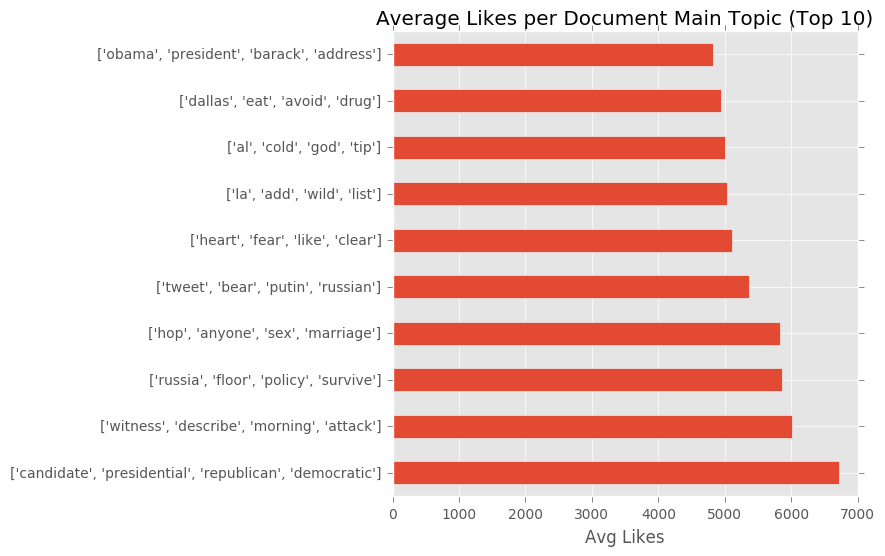

In [246]:
ax = lpt.iloc[:10].plot(title='Average Likes per Document Main Topic (Top 10)', kind='barh',figsize=(6, 6))
ax.set_yticklabels([get_topic_topterms(x) for x in like_per_topic.iloc[:10].index])
ax.set_xlabel("Avg Likes")
ax.set_ylabel('')

## 5. Modeling / Machine Learning

We could here build a simple regression model to predict how many likes a post is likely to receive based on its topic composition.